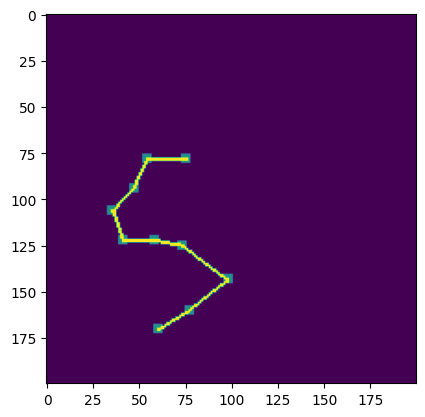

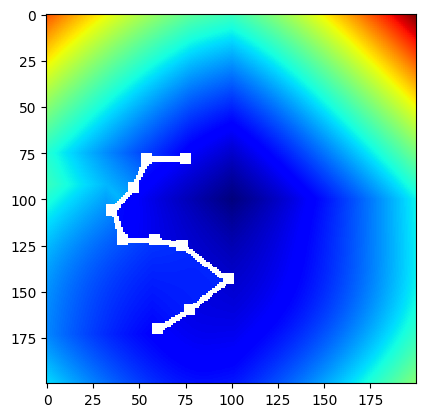

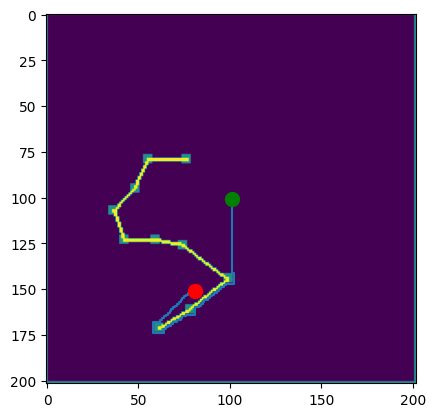

In [2]:
import numpy as np
from discretizer import Discretizer
from a_star import A_Star
import matplotlib.pyplot as plt

class Main():
    def __init__(self) -> None:
        world_coords=[200,200]
        landmarks = np.loadtxt("landmarks.csv", delimiter=",")
        discretizer = Discretizer(landmarks, world_coords=world_coords)
        discretizer.createMap()
        plt.imshow(discretizer.world_map)

        a_star = A_Star(discretizer.middle_point[:2], [150,80], discretizer.world_map)
        path = a_star.find_path()
        plt.figure('Cost map')
        d=a_star.d[1:world_coords[0]+1,1:world_coords[1]+1]
        plt.imshow(d,cmap='jet')

        # plot shortest path
        plt.figure('Shortest path')
        plt.imshow(a_star.world_map)
        plt.plot(path[1],path[0])
        plt.plot(a_star.start[0]+1,a_star.start[1]+1,'g.',markersize=20)
        plt.plot(a_star.goal[1]+1,a_star.goal[0]+1,'r.',markersize=20)
        plt.show()
	
if __name__ == '__main__':
    main = Main()
